In [4]:
import torch
import torch.nn as nn

import sklearn.datasets

import matplotlib.pyplot as plt

from src.data.helpers import rotate
from src.model.models import MLP
from src.visualization.visualize import plot_decision_boundary

from pathlib import Path

import csv
from tqdm.notebook import tqdm
import pandas as pd
from collections import defaultdict

In [3]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

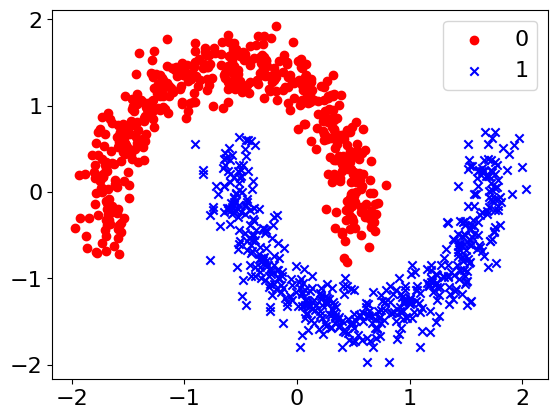

In [4]:
plt.rcParams.update({'font.size': 16})

X_rotated = rotate(X, 0)
plt.scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
plt.scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')

# plt.title("45°")
plt.legend(['0', '1'])
plt.show()

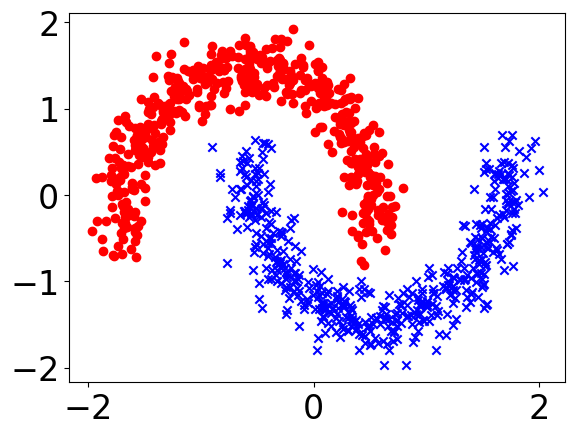

In [6]:
# Vizualization of different rotations
X_rotated = rotate(X, 0)
plt.scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
plt.scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')

# plt.title("45°")
plt.rcParams.update({'font.size': 24})
plt.show()

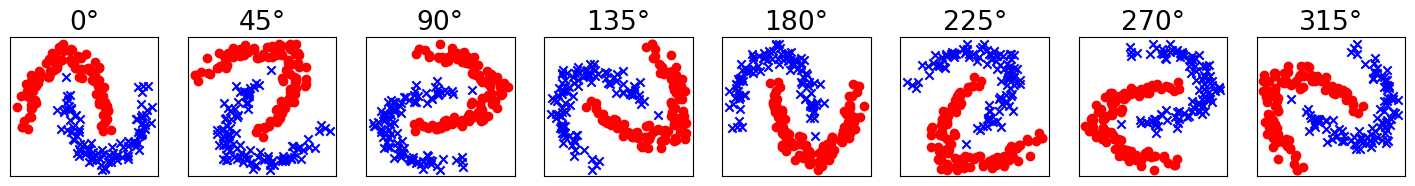

In [18]:
# Vizualization of different rotations
angles = [0, 45, 90, 135, 180, 225, 270, 315]

fig, ax = plt.subplots(1, 8, figsize=(18, 1.8), dpi=100)
X,y = sklearn.datasets.make_moons(n_samples=200, noise=0.1, random_state=42)
X = (X - X.mean(axis=0)) / X.std(axis=0)

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    # ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

# Hide text
plt.setp(ax, xticks=[], yticks=[])

plt.savefig("../reports/two-moons.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Model zoo medium

In [8]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train a model zoo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Zoo config
zoo_name = "eight_angles"
save_dir = Path("../models") / zoo_name
angles = [0, 45, 90, 135, 180, 225, 270, 315]
models_per_angle = 10000
epochs = 60
learning_rate = 0.05

# Model config
input_dim = 2
hidden_dims = [10, 10]
output_dim = 1

seed = 42

# Logging
torch.manual_seed(seed)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    i = 0
    while i < models_per_angle:
        model = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)
        
        if(accuracy >= 0.95):
            model_name = f"model_{angle}_{i}.pth"
            torch.save(model.state_dict(), save_dir/model_name)
            model_accuracies.append((model_name, accuracy))
            i += 1


with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/8 [00:00<?, ?it/s]

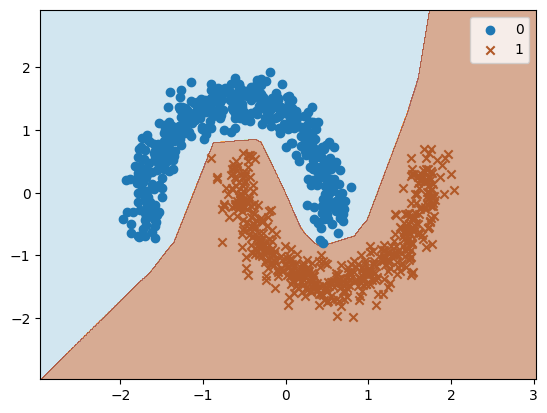

In [33]:
# Plot the decision boundary of the model

model.load_state_dict(torch.load("../models/four_angles/model_0_0.pth"))

plot_decision_boundary(model, X, y)

In [9]:
from utils.data.make_datasets import zoo_to_csv

zoo_name = "eight_angles"
zoo_path = Path("../models/")/zoo_name
zoo_to_csv(zoo_path, f"../data/{zoo_name}.csv")

100%|██████████| 80000/80000 [12:21<00:00, 107.89it/s]


## Model zoo small

In [8]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train a model zoo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Zoo config
zoo_name = "eight_angles_small"
save_dir = Path("../models") / zoo_name
angles = [0, 45, 90, 135, 180, 225, 270, 315]
models_per_angle = 10000
epochs = 200
learning_rate = 0.05

# Model config
input_dim = 2
hidden_dims = [8]
output_dim = 1

seed = 42

# Logging
torch.manual_seed(seed)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    i = 0
    while i < models_per_angle:
        model = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)
        
        if(accuracy >= 0.95):
            model_name = f"model_{angle}_{i}.pth"
            torch.save(model.state_dict(), save_dir/model_name)
            model_accuracies.append((model_name, accuracy))
            i += 1


with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/8 [00:00<?, ?it/s]

In [1]:
from utils.data.make_datasets import zoo_to_csv
from pathlib import Path

zoo_name = "eight_angles_small"
zoo_path = Path("../models/")/zoo_name
zoo_to_csv(zoo_path, f"../data/{zoo_name}.csv")

100%|██████████| 80000/80000 [09:17<00:00, 143.42it/s]


## Extra angle

In [5]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train a model zoo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Zoo config
zoo_name = "extra_angles"
save_dir = Path("../models") / zoo_name
angles = [22, 67]
models_per_angle = 10000
epochs = 200
learning_rate = 0.05

# Model config
input_dim = 2
hidden_dims = [8]
output_dim = 1

seed = 42

# Logging
torch.manual_seed(seed)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    i = 0
    while i < models_per_angle:
        model = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)
        
        if(accuracy >= 0.95):
            model_name = f"model_{angle}_{i}.pth"
            torch.save(model.state_dict(), save_dir/model_name)
            model_accuracies.append((model_name, accuracy))
            i += 1


with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
from src.data.make_datasets import zoo_to_csv
from pathlib import Path

zoo_name = "extra_angles"
zoo_path = Path("../models/")/zoo_name
zoo_to_csv(zoo_path, f"../data/{zoo_name}.csv")

100%|██████████| 20000/20000 [02:51<00:00, 116.45it/s]


In [10]:
import os
from src.data.helpers import model_to_list, get_accuracy, get_moons_dataset

X, y = get_moons_dataset()

input_dir = "../models/accuracy"

with(open("../data/accuracy.csv", "w")) as f:
    fieldnames = [f"weight_{i}" for i in range(0, 33)]
    fieldnames.insert(0, "model_name")
    fieldnames.append("accuracy")
    fieldnames.append("angle")
    writer = csv.writer(f, lineterminator = '\n')
    writer.writerow(fieldnames)

    models = os.listdir(input_dir)
    for model in tqdm(models):
        angle = int(model.split("_")[1])
        m = MLP(2, [8], 1)
        m.load_state_dict(torch.load(f"{input_dir}/{model}"))
        weights = model_to_list(m)
        row = weights.tolist()

        X_rotated = rotate(X, angle)
        accuracy = get_accuracy(m, X_rotated, y)

        row.append(accuracy)
        row.append(angle)
        row.insert(0, model)
        writer.writerow(row)

  0%|          | 0/1600 [00:00<?, ?it/s]

## Model zoo big

In [2]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train a model zoo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Zoo config
zoo_name = "eight_angles_big"
save_dir = Path("../models") / zoo_name
angles = [0, 45, 90, 135, 180, 225, 270, 315]
models_per_angle = 10000
epochs = 60
learning_rate = 0.05

# Model config
input_dim = 2
hidden_dims = [10, 10, 10]
output_dim = 1

seed = 42

# Logging
torch.manual_seed(seed)
model_accuracies = []

for angle in tqdm(angles):
    X_rotated = rotate(X, angle)
    X_tensor = torch.tensor(X_rotated, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    i = 0
    while i < models_per_angle:
        model = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim)
        model.to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_tensor).flatten()
            loss = criterion(y_pred, y_tensor)
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = model(X_tensor).flatten()
        correct = (y_pred.round() == y_tensor).sum().item()
        accuracy = correct / len(y)
        
        if(accuracy >= 0.95):
            model_name = f"model_{angle}_{i}.pth"
            torch.save(model.state_dict(), save_dir/model_name)
            model_accuracies.append((model_name, accuracy))
            i += 1


with open(f"../reports/{zoo_name}.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["model_name", "accuracy"])
    writer.writerows(model_accuracies)


  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
from src.data.make_datasets import zoo_to_csv
import os
from src.data.helpers import model_to_list

zoo_name = "eight_angles_big"
zoo_path = Path("../models/")/zoo_name

input_dim = 2
hidden_dims = [10, 10, 10]
output_dim = 1

with(open(f"../data/{zoo_name}.csv", "w")) as f:
    fieldnames = [f"weight_{i}" for i in range(0, 33)]
    fieldnames.insert(0, "model_name")
    fieldnames.append("angle")
    writer = csv.writer(f, lineterminator = '\n')
    writer.writerow(fieldnames)

    models = os.listdir(zoo_path)
    for model in tqdm(models):
        angle = int(model.split("_")[1])
        m = MLP(input_dim, hidden_dims, output_dim)
        m.load_state_dict(torch.load(f"{zoo_path}/{model}"))
        weights = model_to_list(m)
        row = weights.tolist()
        row.append(angle)
        row.insert(0, model)
        writer.writerow(row)

  0%|          | 0/80000 [00:00<?, ?it/s]

## Zoo accuracies

In [9]:
zoo_small = pd.read_csv("../reports/eight_angles_small.csv")
zoo_medium = pd.read_csv("../reports/eight_angles.csv")
zoo_big = pd.read_csv("../reports/eight_angles_big.csv")

zoo_small_accuracies = zoo_small["accuracy"]
zoo_medium_accuracies = zoo_medium["accuracy"]
zoo_big_accuracies = zoo_big["accuracy"]

print("Small zoo average accuracy: ", zoo_small_accuracies.mean()*100)
print("Small zoo accuracy std:", zoo_small_accuracies.std()*100)
print("Medium zoo average accuracy:", zoo_medium_accuracies.mean()*100)
print("Medium zoo accuracy std:", zoo_medium_accuracies.std()*100)
print("Big zoo average accuracy:", zoo_big_accuracies.mean()*100)
print("Big zoo accuracy std:", zoo_big_accuracies.std()*100)


Small zoo average accuracy: 99.87490625000001
Small zoo accuracy std: 0.20161581491204467
Medium zoo average accuracy: 99.85036625000001
Medium zoo accuracy std: 0.4927772328633429
Big zoo average accuracy: 99.95387375
Big zoo accuracy std: 0.3083385841400141


## Test and train set distances

In [5]:
from src.data.datasets import ModelParamsDataset

In [13]:
def find_closest_vectors_batched(dataset_train, dataset_test, batch_size=100):
    """
    Finds the closest vectors in dataset_train for each vector in dataset_test using batching.
    Args:
        dataset_train: Tensor of shape (N_train, D)
        dataset_test: Tensor of shape (N_test, D)
        batch_size: Size of batches to process dataset_test
    Returns:
        closest_vectors: Tensor of shape (N_test, D)
        closest_indices: Tensor of shape (N_test,)
    """
    closest_vectors = []
    closest_indices = []
    all_distances = []
    for i in range(0, len(dataset_test), batch_size):
        batch_test = dataset_test[i:i + batch_size] 
        distances = torch.cdist(batch_test, dataset_train, p=2)
        
        batch_indices = torch.argmin(distances, dim=1)
        batch_vectors = dataset_train[batch_indices] 
        
        all_distances.append(distances)
        closest_vectors.append(batch_vectors)
        closest_indices.append(batch_indices)
    
    closest_vectors = torch.cat(closest_vectors, dim=0)
    closest_indices = torch.cat(closest_indices, dim=0)
    average_distance = torch.stack(all_distances).mean()
    distances_std = torch.stack(all_distances).std()

    return closest_vectors, closest_indices, average_distance, distances_std

In [34]:
dataset_seed = 42
dataset_path = "../data/eight_angles_small.csv"
dataset_splits = [0.7, 0.2, 0.1]
batch_size = 128
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

dataset_train_tensor = torch.stack([sample for sample, _ in dataset_train])
dataset_test_tensor = torch.stack([sample for sample, _ in dataset_test])
closest_vectors, closest_indices, average_distance, distances_std = find_closest_vectors_batched(dataset_train_tensor, dataset_test_tensor)

closest_distances = []
for i, (sample, angle) in enumerate(dataset_test):
    distance = torch.dist(sample, closest_vectors[i])
    closest_distances.append(distance.item())


closest_distance_mean = torch.tensor(closest_distances).mean()
closest_distance_std = torch.tensor(closest_distances).std()
closest_distance_min = torch.tensor(closest_distances).min()
closest_distance_max = torch.tensor(closest_distances).max()

print("Small ZOO")
print("Distances mean:", average_distance.item())
print("Distances std:", distances_std.item())
print("Closest distances mean:", closest_distance_mean.item())
print("Closest distances std:", closest_distance_std.item())
print("Closest distances min:", closest_distance_min.item())
print("Closest distances max:", closest_distance_max.item())

Small ZOO
Distances mean: 18.021638870239258
Distances std: 1.8541221618652344
Closest distances mean: 6.961311340332031
Closest distances std: 1.2049751281738281
Closest distances min: 2.3812718391418457
Closest distances max: 12.979178428649902


In [33]:
dataset_seed = 42
dataset_path = "../data/eight_angles_medium.csv"
dataset_splits = [0.7, 0.2, 0.1]
batch_size = 128
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

dataset_train_tensor = torch.stack([sample for sample, _ in dataset_train])
dataset_test_tensor = torch.stack([sample for sample, _ in dataset_test])
closest_vectors, closest_indices, average_distance, distances_std = find_closest_vectors_batched(dataset_train_tensor, dataset_test_tensor)

closest_distances = []
for i, (sample, angle) in enumerate(dataset_test):
    distance = torch.dist(sample, closest_vectors[i])
    closest_distances.append(distance.item())


closest_distance_mean = torch.tensor(closest_distances).mean()
closest_distance_std = torch.tensor(closest_distances).std()
closest_distance_min = torch.tensor(closest_distances).min()
closest_distance_max = torch.tensor(closest_distances).max()

print("Medium ZOO")
print("Distances mean:", average_distance.item())
print("Distances std:", distances_std.item())
print("Closest distances mean:", closest_distance_mean.item())
print("Closest distances std:", closest_distance_std.item())
print("Closest distances min:", closest_distance_min.item())
print("Closest distances max:", closest_distance_max.item())

Medium ZOO
Distances mean: 14.78957462310791
Distances std: 0.9526228904724121
Closest distances mean: 10.600822448730469
Closest distances std: 0.6108875274658203
Closest distances min: 8.03511905670166
Closest distances max: 12.678970336914062


In [32]:
dataset_seed = 42
dataset_path = "../data/eight_angles_big.csv"
dataset_splits = [0.7, 0.2, 0.1]
batch_size = 128
dataset = ModelParamsDataset(dataset_path, 45)

torch.manual_seed(dataset_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, dataset_splits)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

dataset_train_tensor = torch.stack([sample for sample, _ in dataset_train])
dataset_test_tensor = torch.stack([sample for sample, _ in dataset_test])
closest_vectors, closest_indices, average_distance, distances_std = find_closest_vectors_batched(dataset_train_tensor, dataset_test_tensor)

closest_distances = []
for i, (sample, angle) in enumerate(dataset_test):
    distance = torch.dist(sample, closest_vectors[i])
    closest_distances.append(distance.item())

closest_distance_mean = torch.tensor(closest_distances).mean()
closest_distance_std = torch.tensor(closest_distances).std()
closest_distance_min = torch.tensor(closest_distances).min()
closest_distance_max = torch.tensor(closest_distances).max()

print("BIG ZOO")
print("Distances mean:", average_distance.item())
print("Distances std:", distances_std.item())
print("Closest distances mean:", closest_distance_mean.item())
print("Closest distances std:", closest_distance_std.item())
print("Closest distances min:", closest_distance_min.item())
print("Closest distances max:", closest_distance_max.item())

BIG ZOO
Distances mean: 14.950889587402344
Distances std: 0.7902837991714478
Closest distances mean: 11.705355644226074
Closest distances std: 0.5316880941390991
Closest distances min: 9.284794807434082
Closest distances max: 13.66835880279541
